In [31]:
import numpy as np
import matplotlib as mlp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

from sklearn.linear_model import LinearRegression
from scipy.fft import fft, rfftfreq, rfft

import prediction_functions as pf

# Project for the Predictions and Predictability Class 2023/24

We are predicting the number of the Cyclones in the Tropical Atlantic per year, using the HURDAT2 observation dataset from the US' National Hurricane Center. 

Maybe we will additionally look into ocean surface waves or into a path of the cyclones/most cyclone genesis density.

## Exploring Data:

In [32]:
df = pd.read_csv("data/tcatlantic.csv")

In [33]:
df.head()

,Year,Tropical Storms,Hurricanes,Major Hurricanes
0,1851,6,3,1
1,1852,5,5,1
2,1853,8,4,2
3,1854,5,3,1
4,1855,5,4,1


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Year              172 non-null    int64
 1   Tropical Storms   172 non-null    int64
 2   Hurricanes        172 non-null    int64
 3   Major Hurricanes  172 non-null    int64
dtypes: int64(4)
memory usage: 5.5 KB


In [35]:
df.describe()

,Year,Tropical Storms,Hurricanes,Major Hurricanes
count,172.000000,172.000000,172.000000,172.000000
mean,1936.500000,9.819767,5.534884,1.959302
std,49.796252,4.548255,2.603181,1.694013
min,1851.000000,1.000000,0.000000,0.000000
25%,1893.750000,6.000000,4.000000,1.000000
50%,1936.500000,9.000000,5.000000,2.000000
75%,1979.250000,12.000000,7.000000,3.000000
max,2022.000000,30.000000,15.000000,7.000000


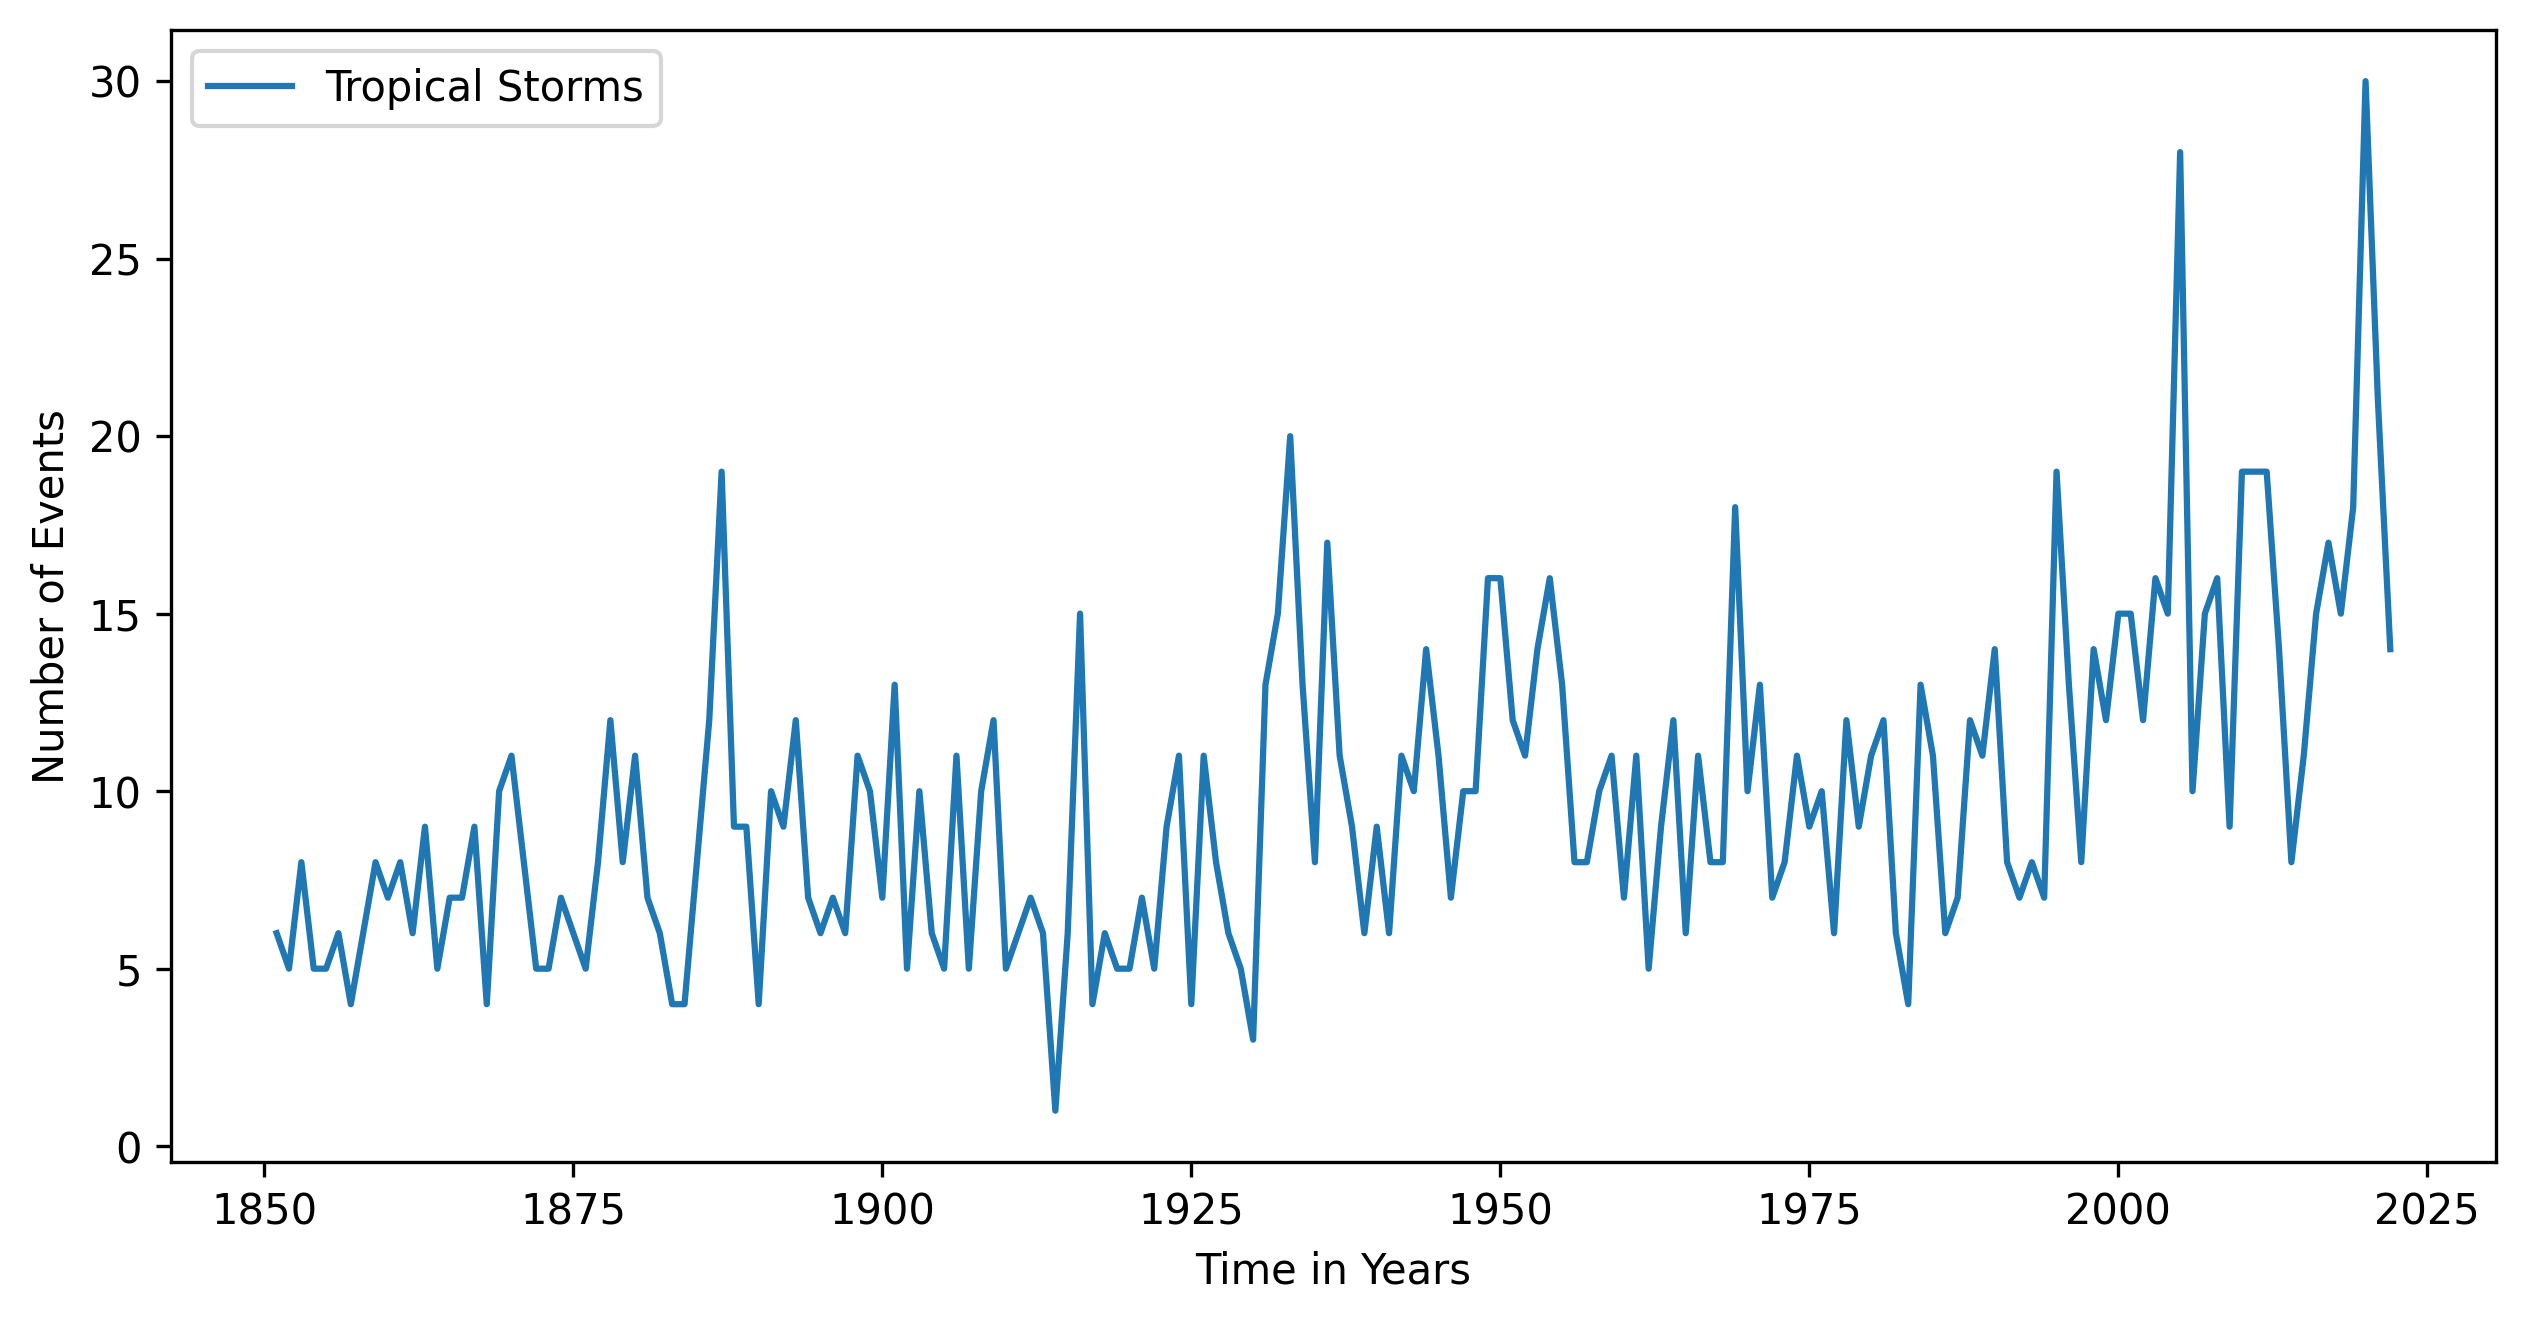

In [36]:
plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Tropical Storms")
#plt.plot(df["Year"],df["Hurricanes"], label = "Hurricanes")
#plt.plot(df["Year"],df["Major Hurricanes"], label = "Major Hurricanes")
plt.xlabel("Time in Years")
plt.ylabel("Number of Events")
plt.legend()

## Functions:


### General:



In [37]:
def acf(x, length=150):
    """
    From https://stackoverflow.com/questions/643699/how-can-i-use-numpy-correlate-to-do-autocorrelation

    This function computes the statistical autocorrelation of the data with itself with different time differences.

    Parameters:
    - x (numpy array): Array with the data
    - length (int, optional): maximum difference in time steps (Years) to be looked at.


    Returns:
    - result (numpy array): array of correlation coefficients

    """
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1]  \
        for i in range(1, length)])

In [38]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

### Linear Regression:

In [39]:
def f(m,b,start,end):
    values = m*np.arange(start,end,1)+b
    return values

## Analysis:

### Looking at the Data:

Text(0, 0.5, 'Pearson Correlation Coefficient')

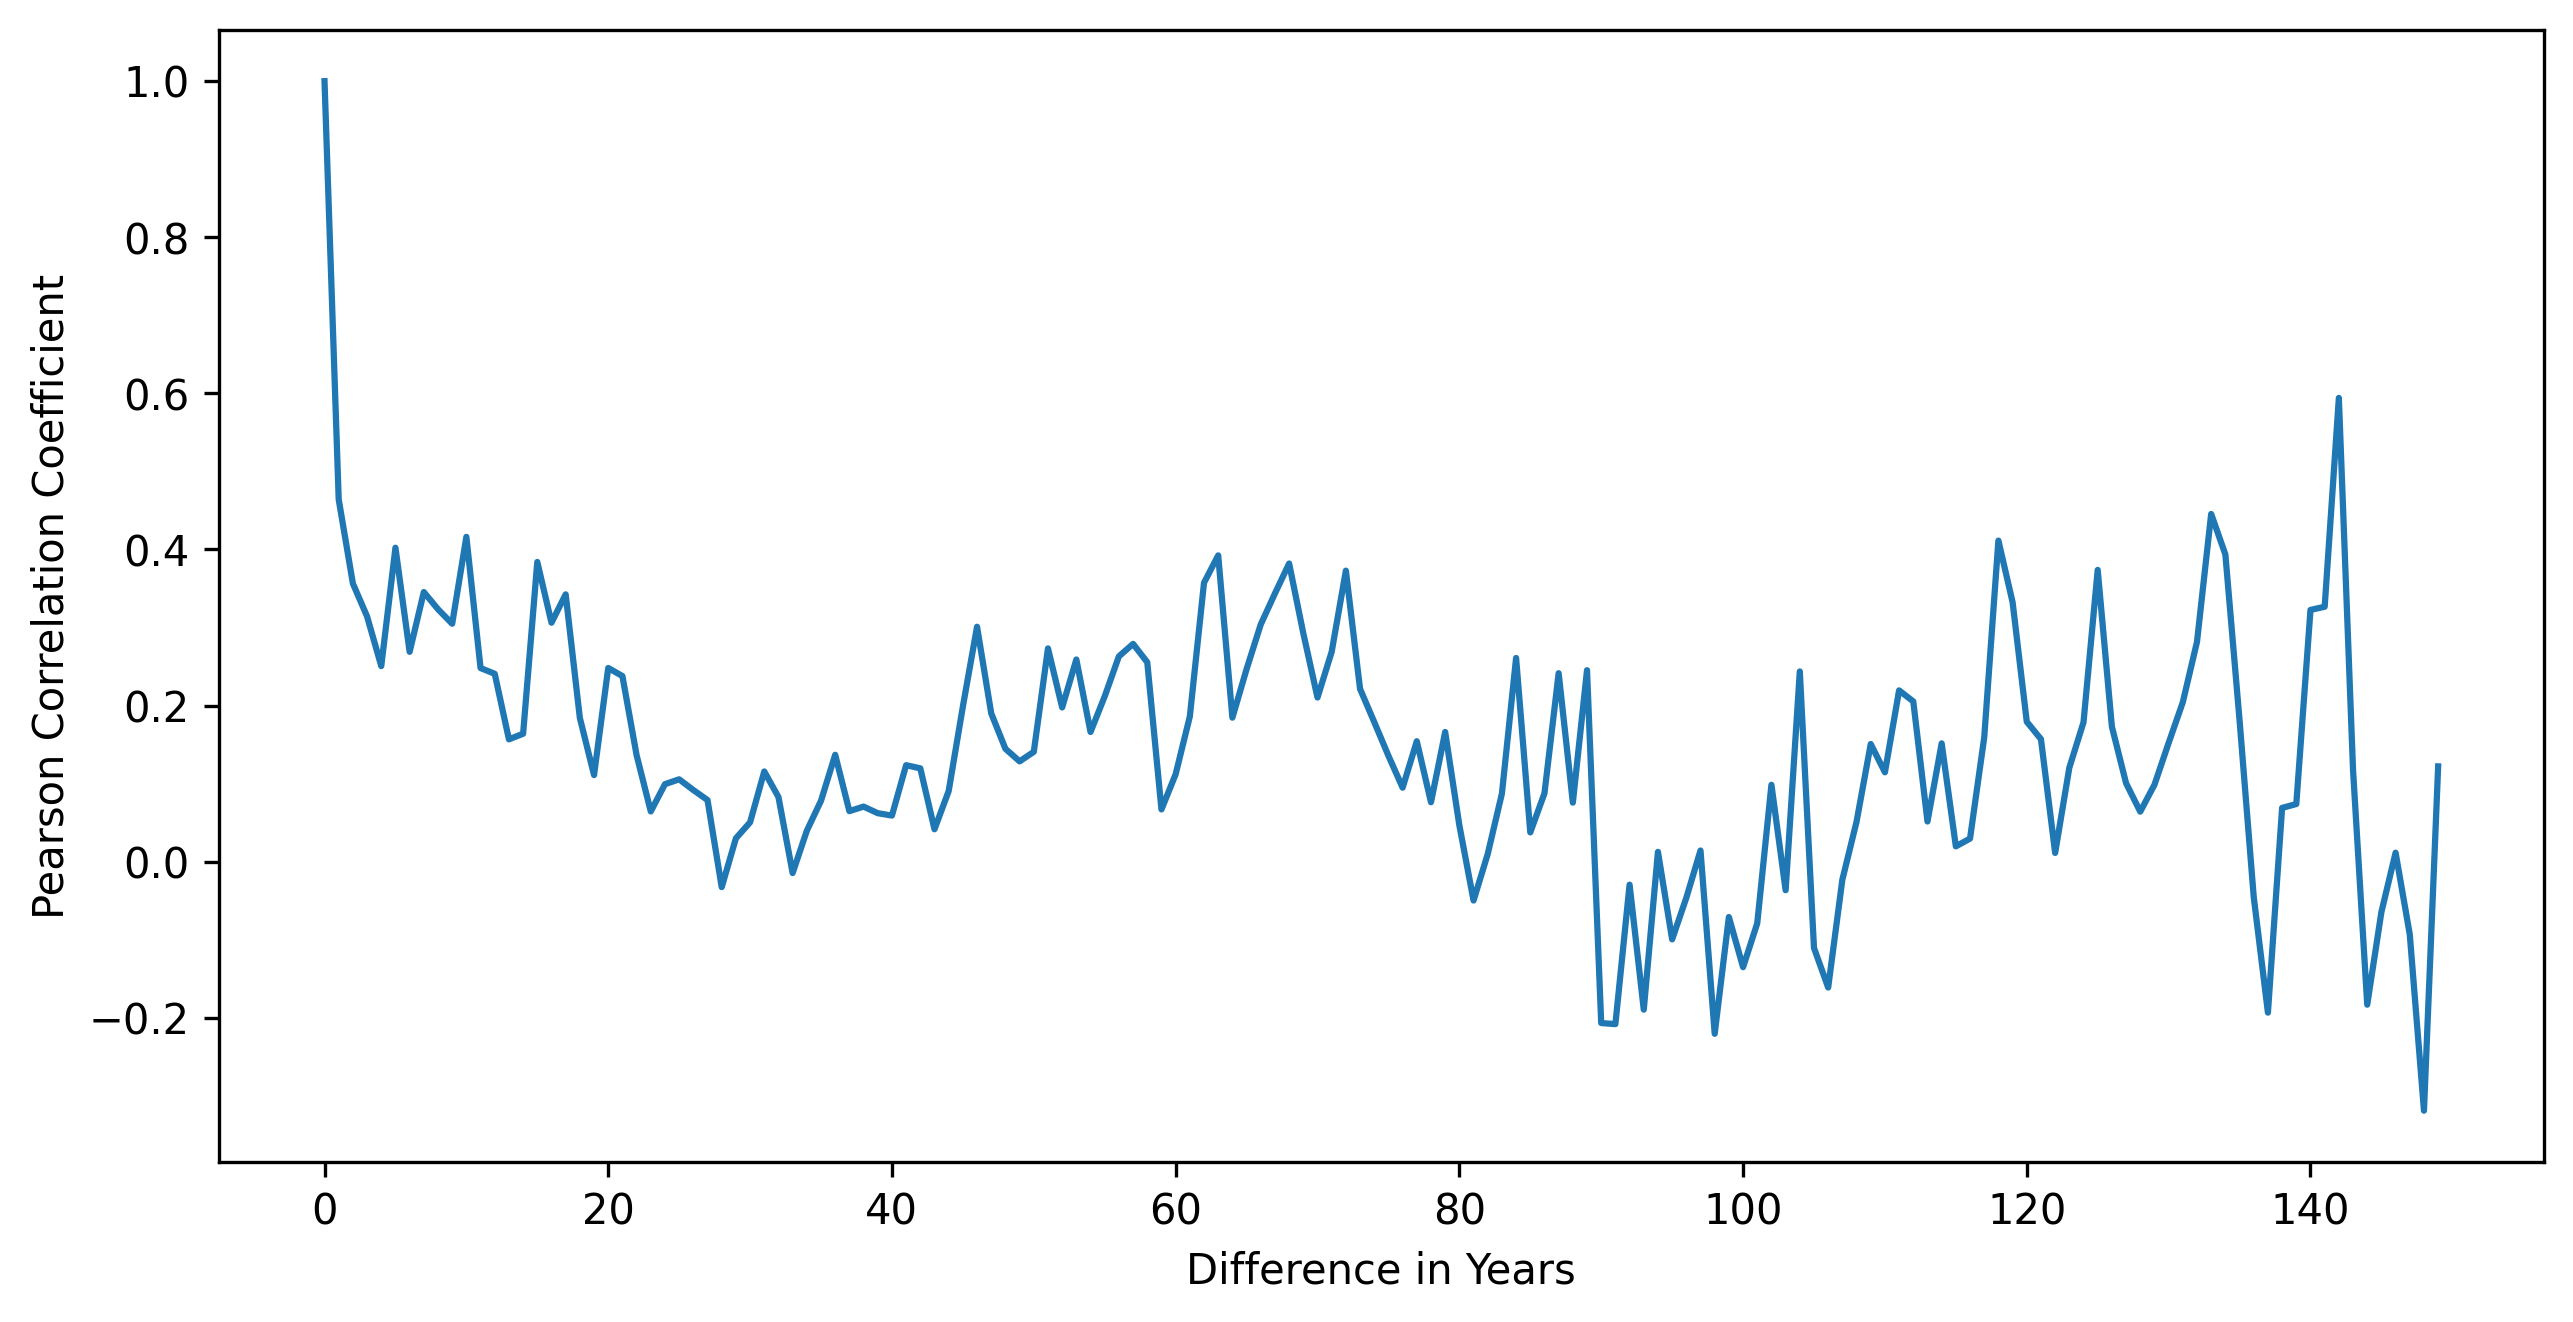

In [40]:
plt.figure(figsize = (10,5),dpi = 300)

x = acf(df["Tropical Storms"].to_numpy())
plt.plot(x)
plt.xlabel("Difference in Years")
plt.ylabel("Pearson Correlation Coefficient")

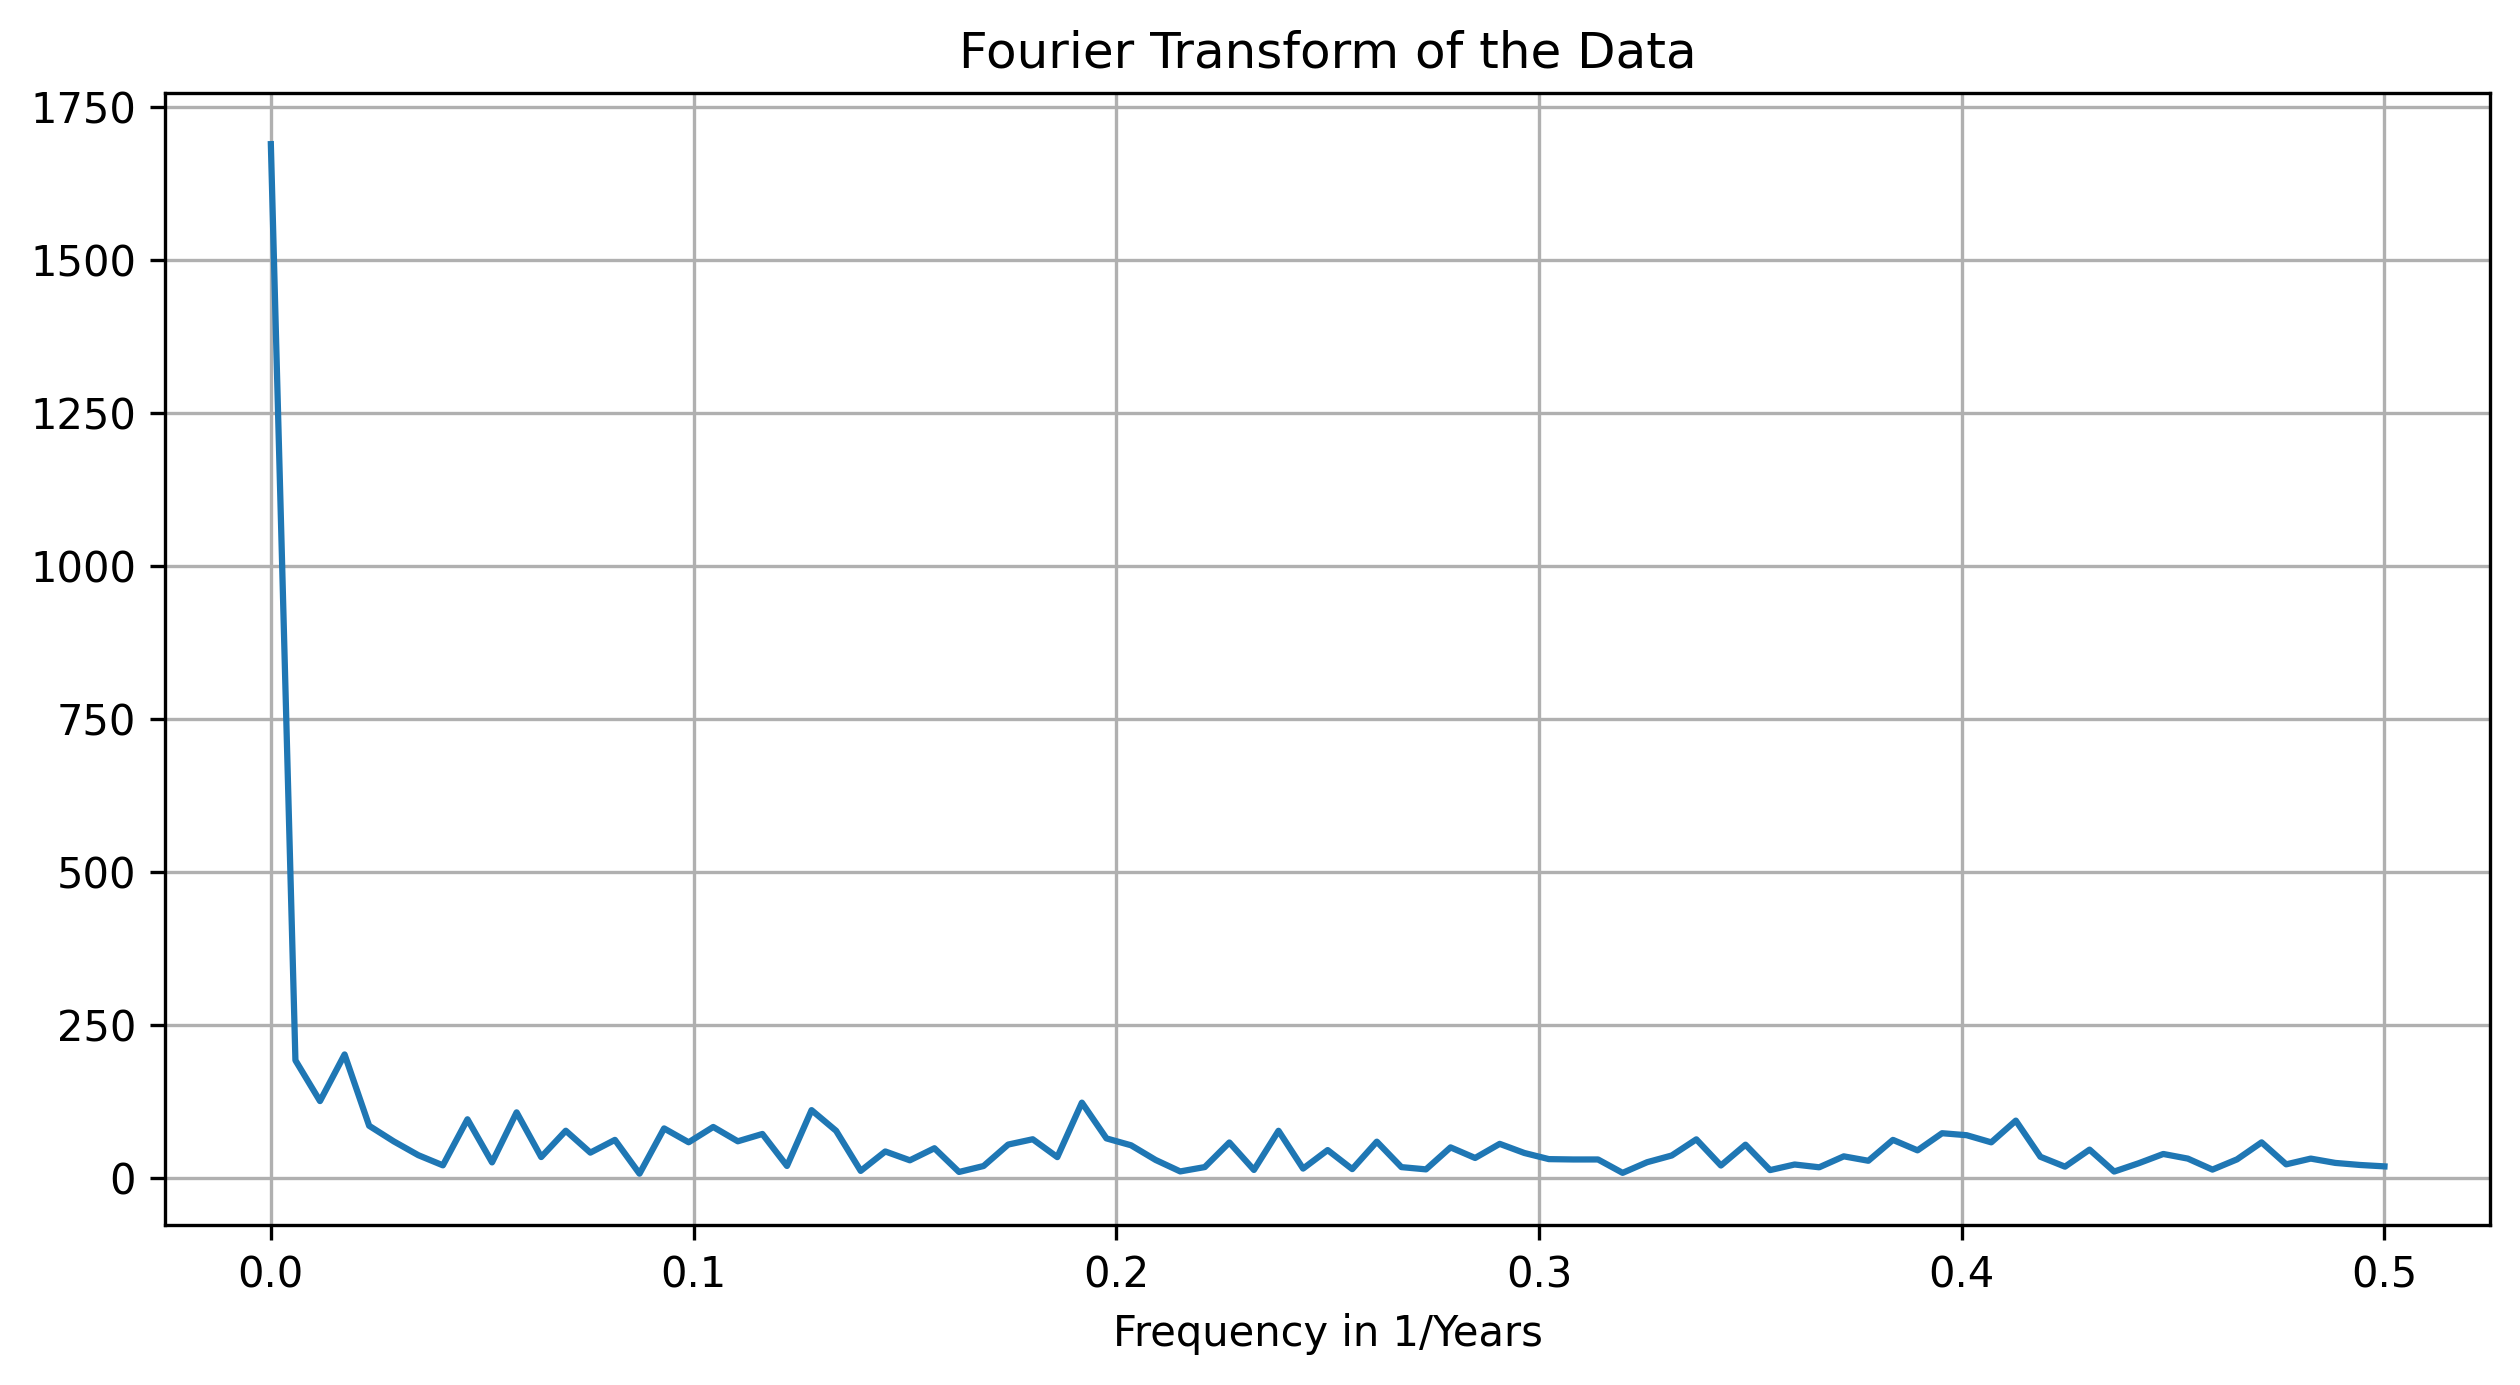

In [41]:
# Number of sample points
N = len(df["Year"])
T = 1
x = df["Year"]
y = df["Tropical Storms"]
yf = rfft(y)
xf = rfftfreq(N,T)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(xf, np.abs(yf))
plt.xlabel("Frequency in 1/Years")
plt.title("Fourier Transform of the Data")
plt.grid()
plt.show()

### Making Predictions:

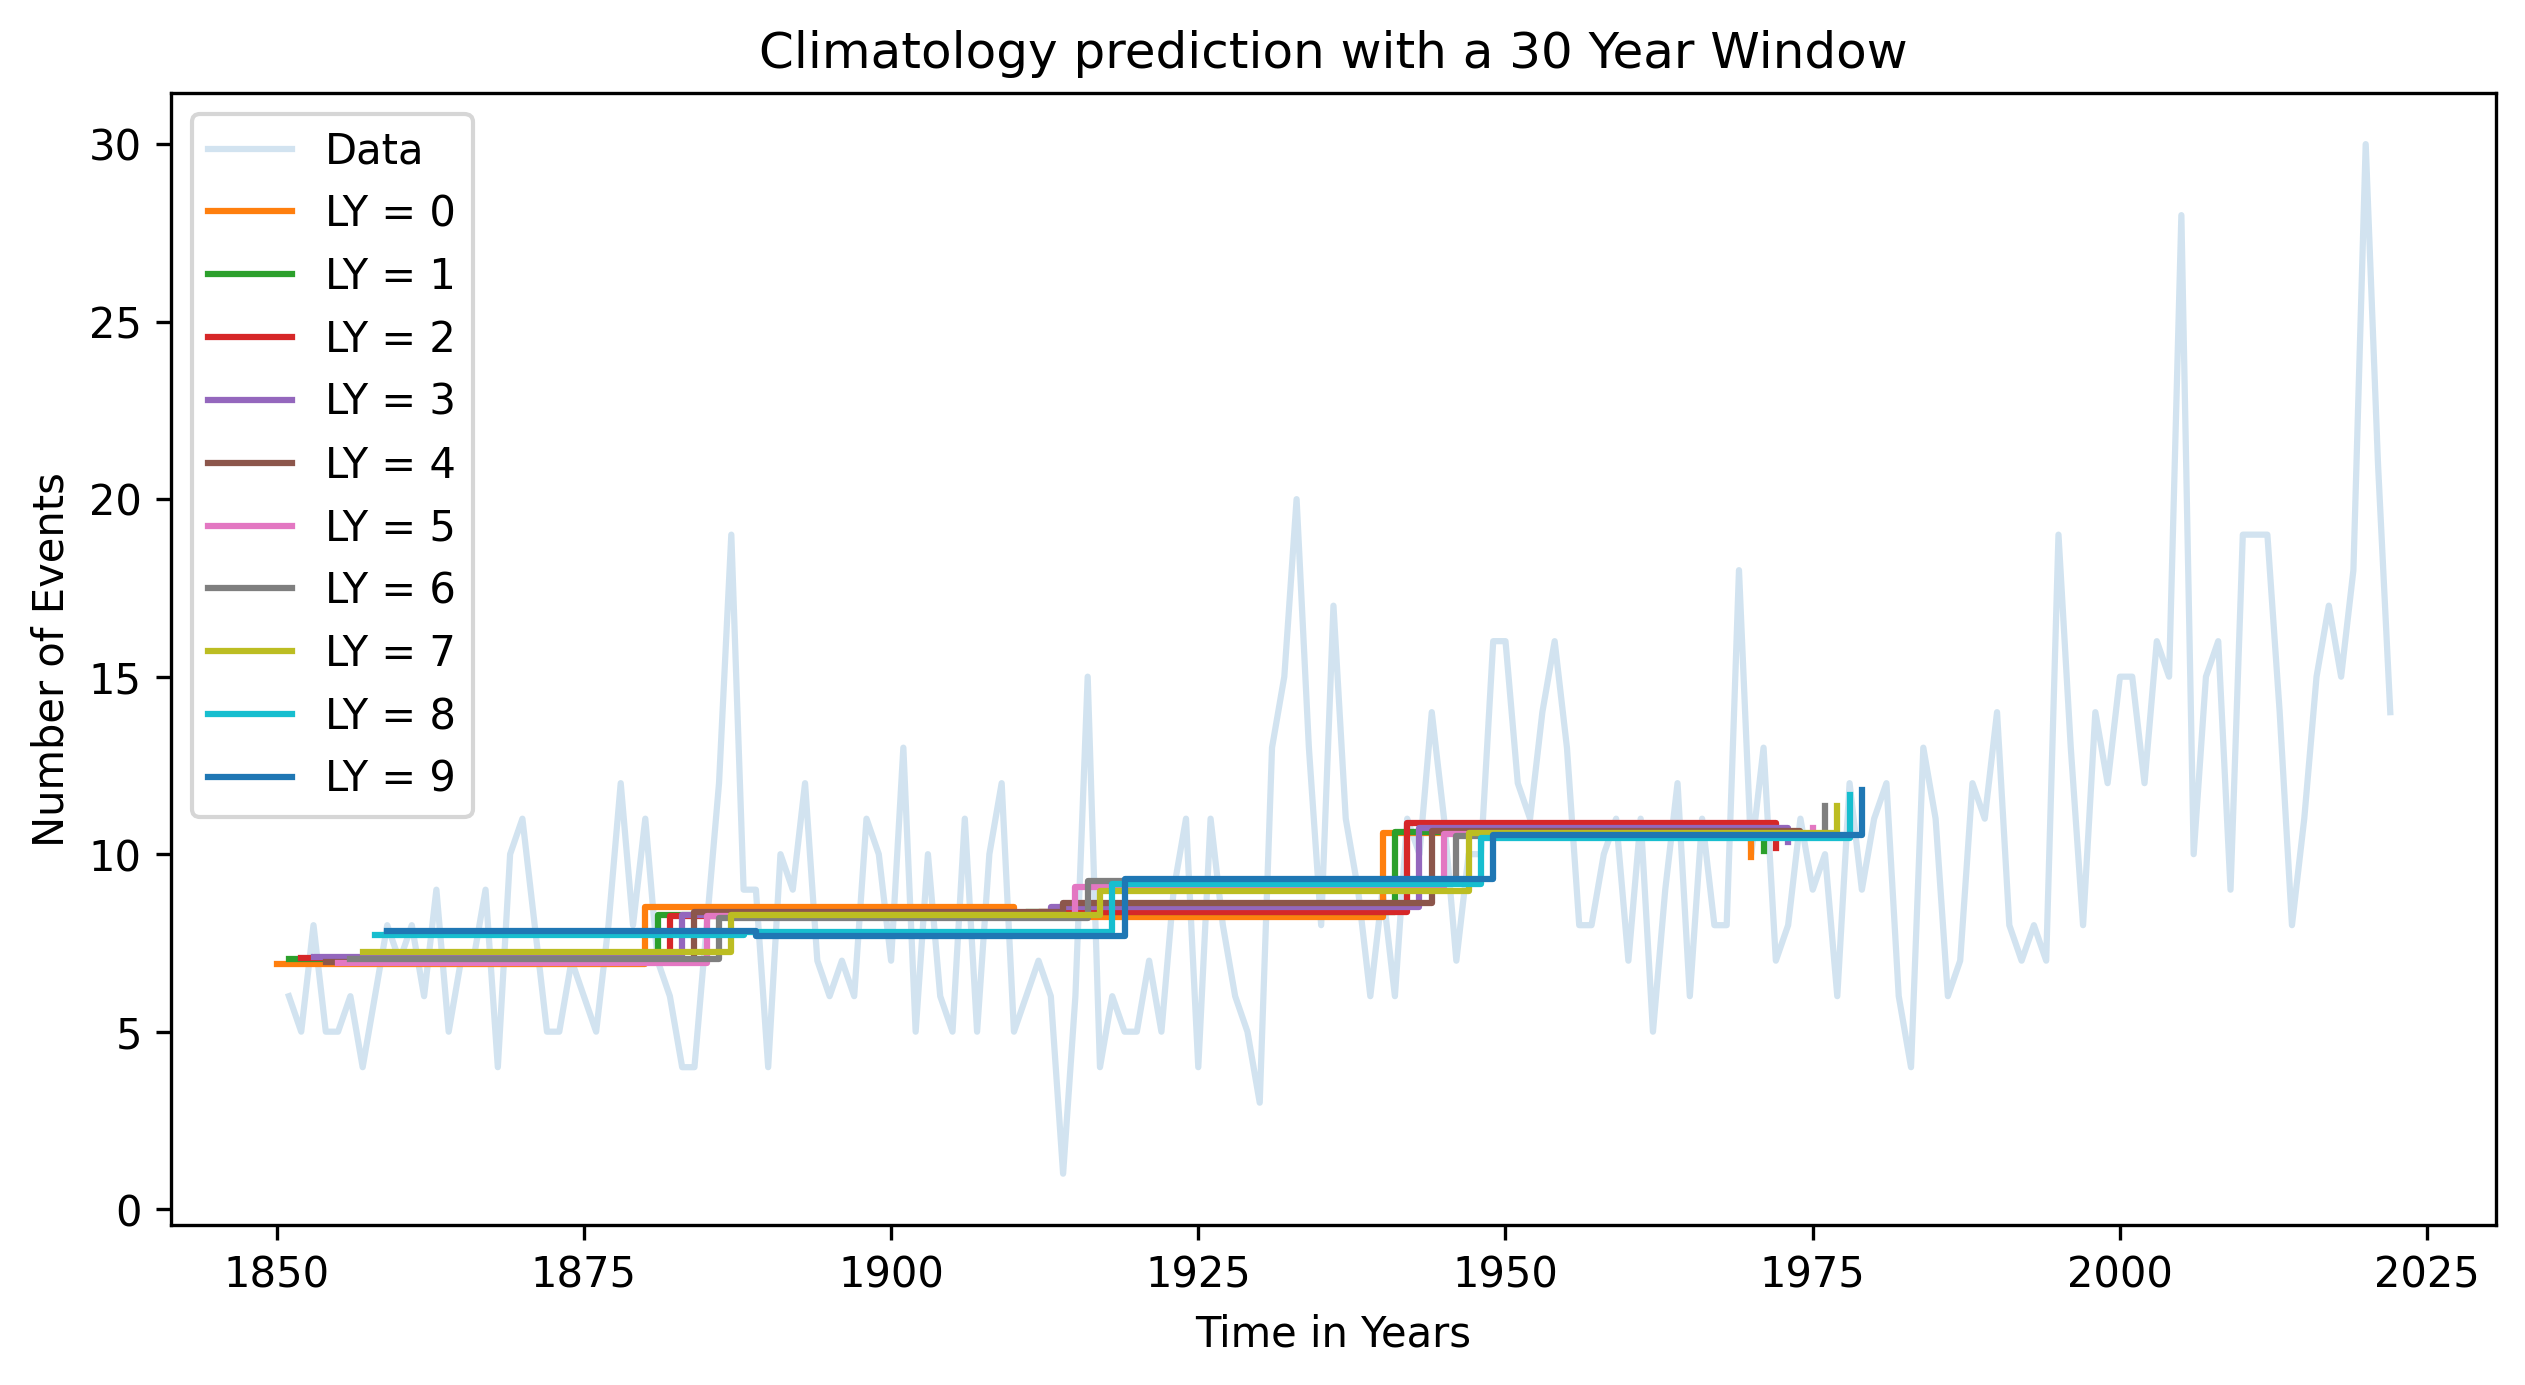

In [42]:
start_year = 1850
end_year = 2025
window_length = 30
num_ly = 10
predict,starts,ends = pf.climatology_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.2)
#plt.plot(starts,predict)
for ly in range(num_ly):
    plt.plot(starts[ly::window_length], predict[ly::window_length], drawstyle='steps-post', label=f'LY = {ly}')
plt.legend(loc = "best")
plt.title(f"Climatology prediction with a {window_length} Year Window")
plt.xlabel("Time in Years")
plt.ylabel("Number of Events")
plt.legend()

plt.savefig(f"plots/climatology_numly{num_ly}_window{window_length}.pdf")

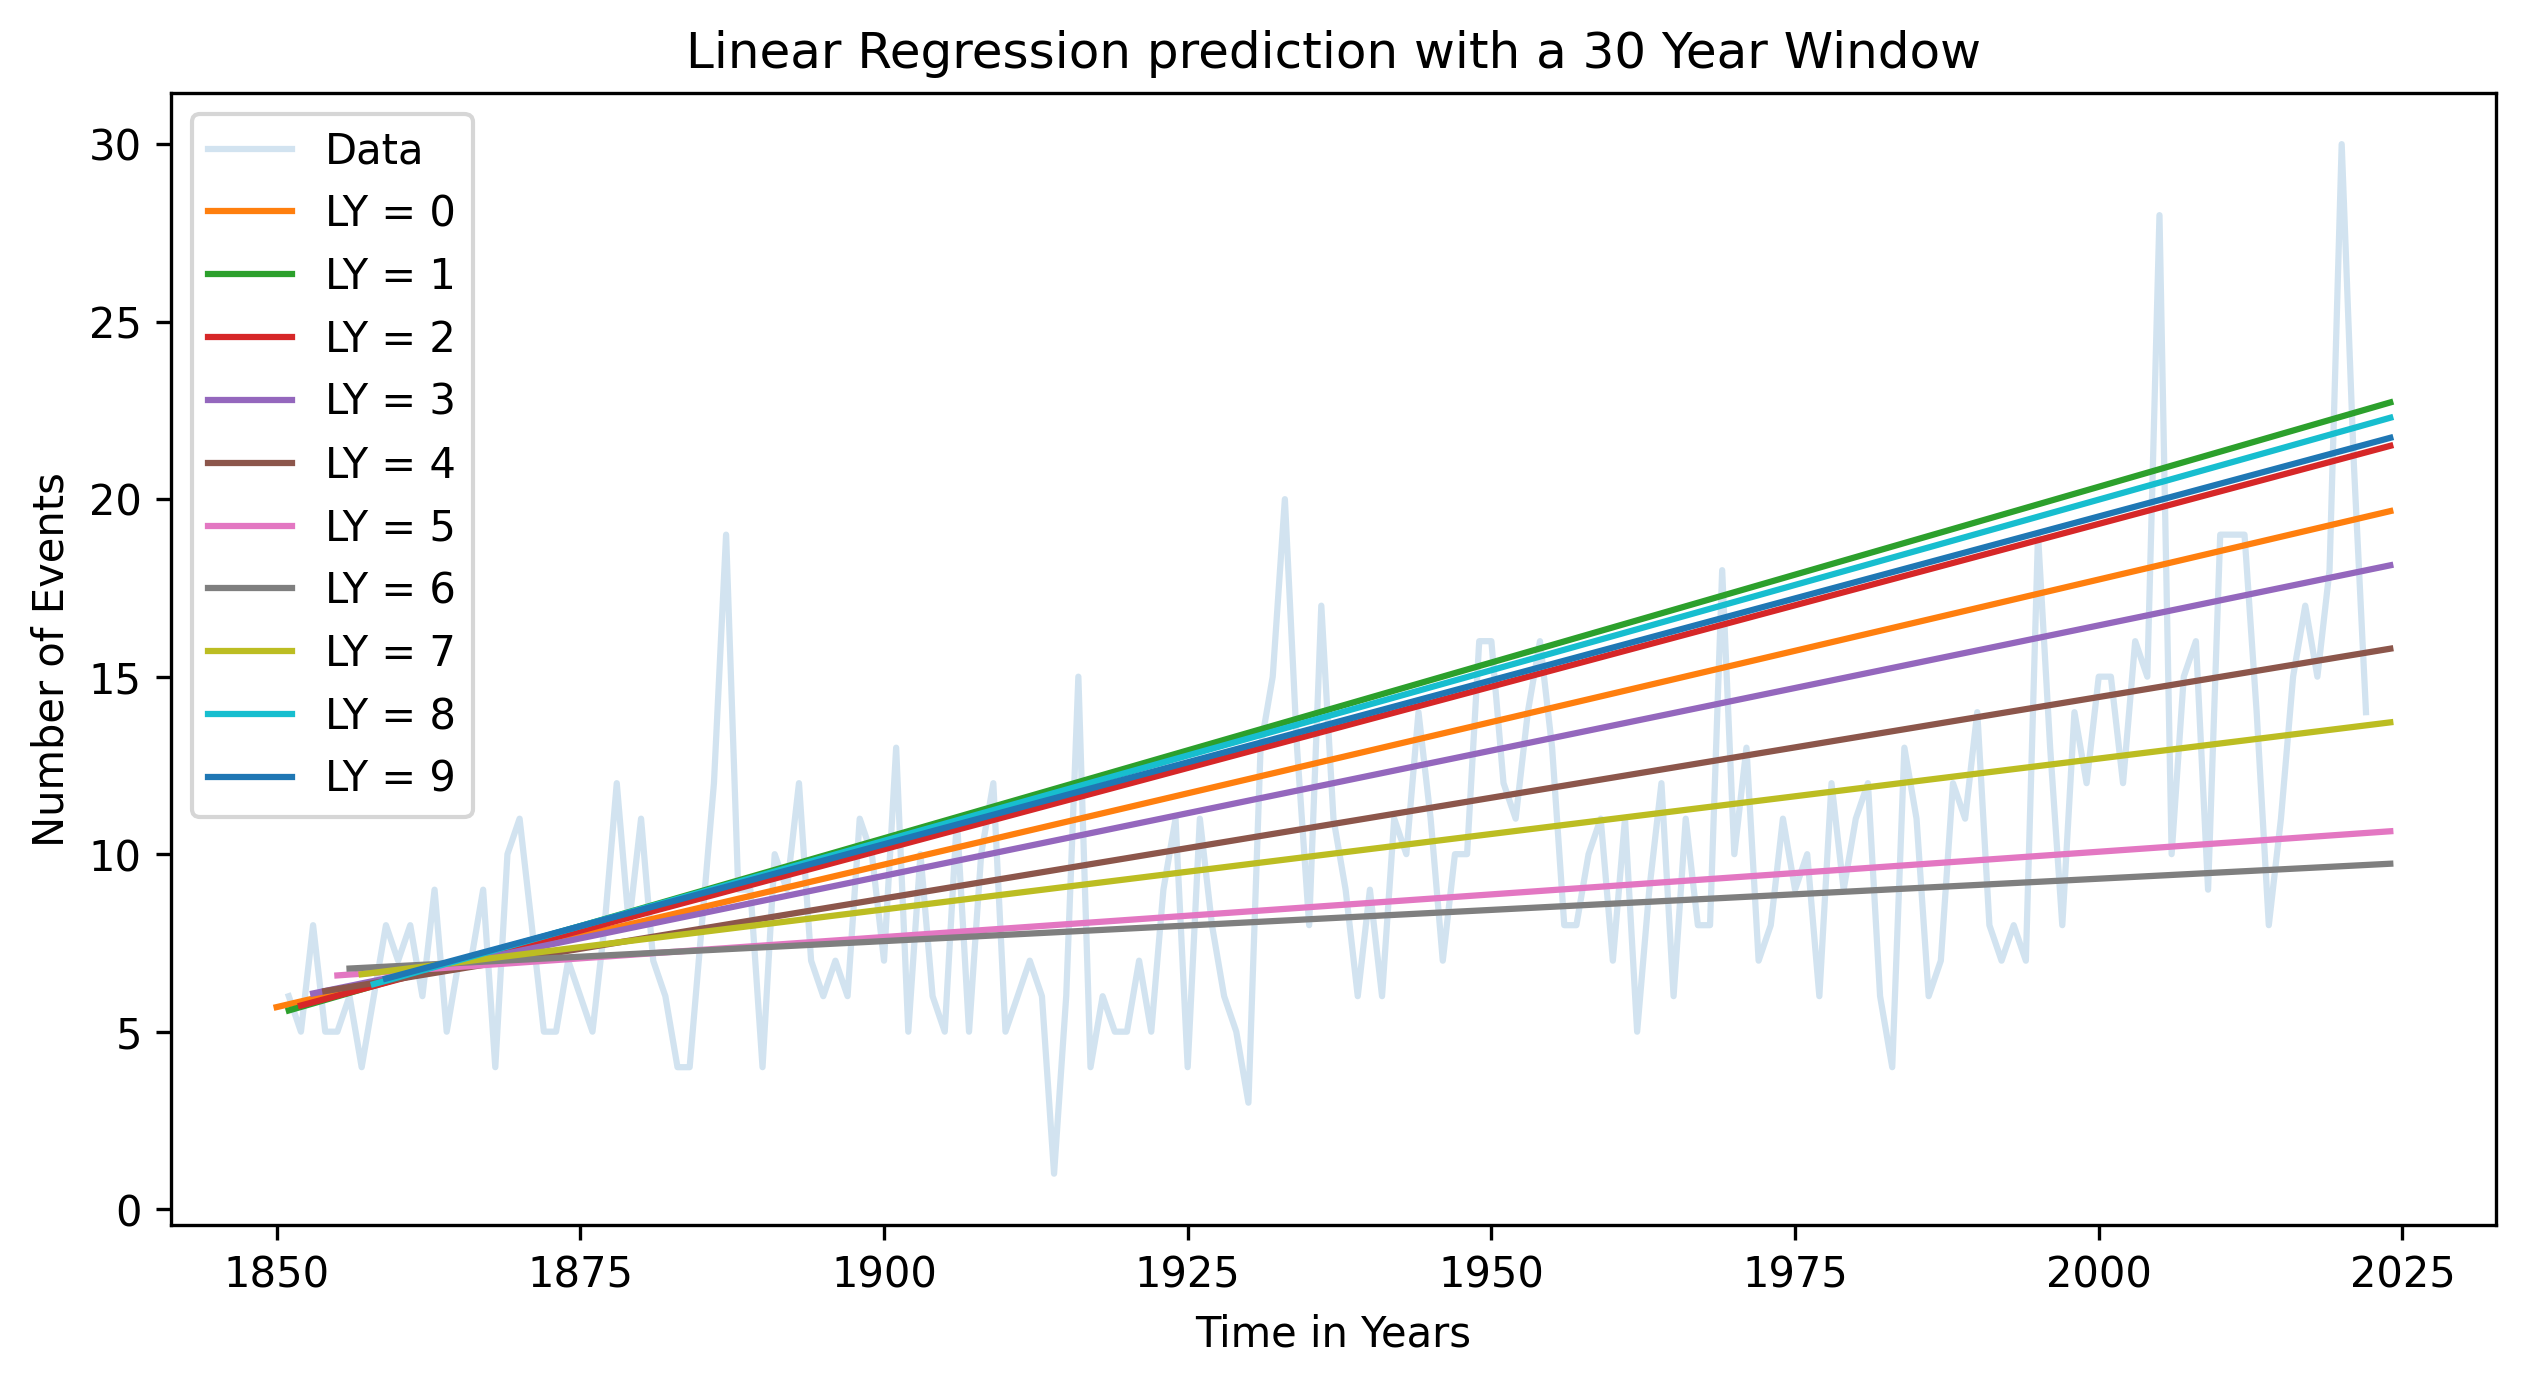

In [43]:
start_year = 1850
end_year = 2025
window_length = 30
num_ly = 10
predict,starts = pf.linear_reg_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.2)
for ly in range(num_ly):
    plt.plot(np.arange(starts[ly],2025),predict[ly], label=f'LY = {ly}')
plt.legend(loc = "best")
plt.title(f"Linear Regression prediction with a {window_length} Year Window")
plt.xlabel("Time in Years")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"plots/linear_reg_numly{num_ly}_window{window_length}.pdf")

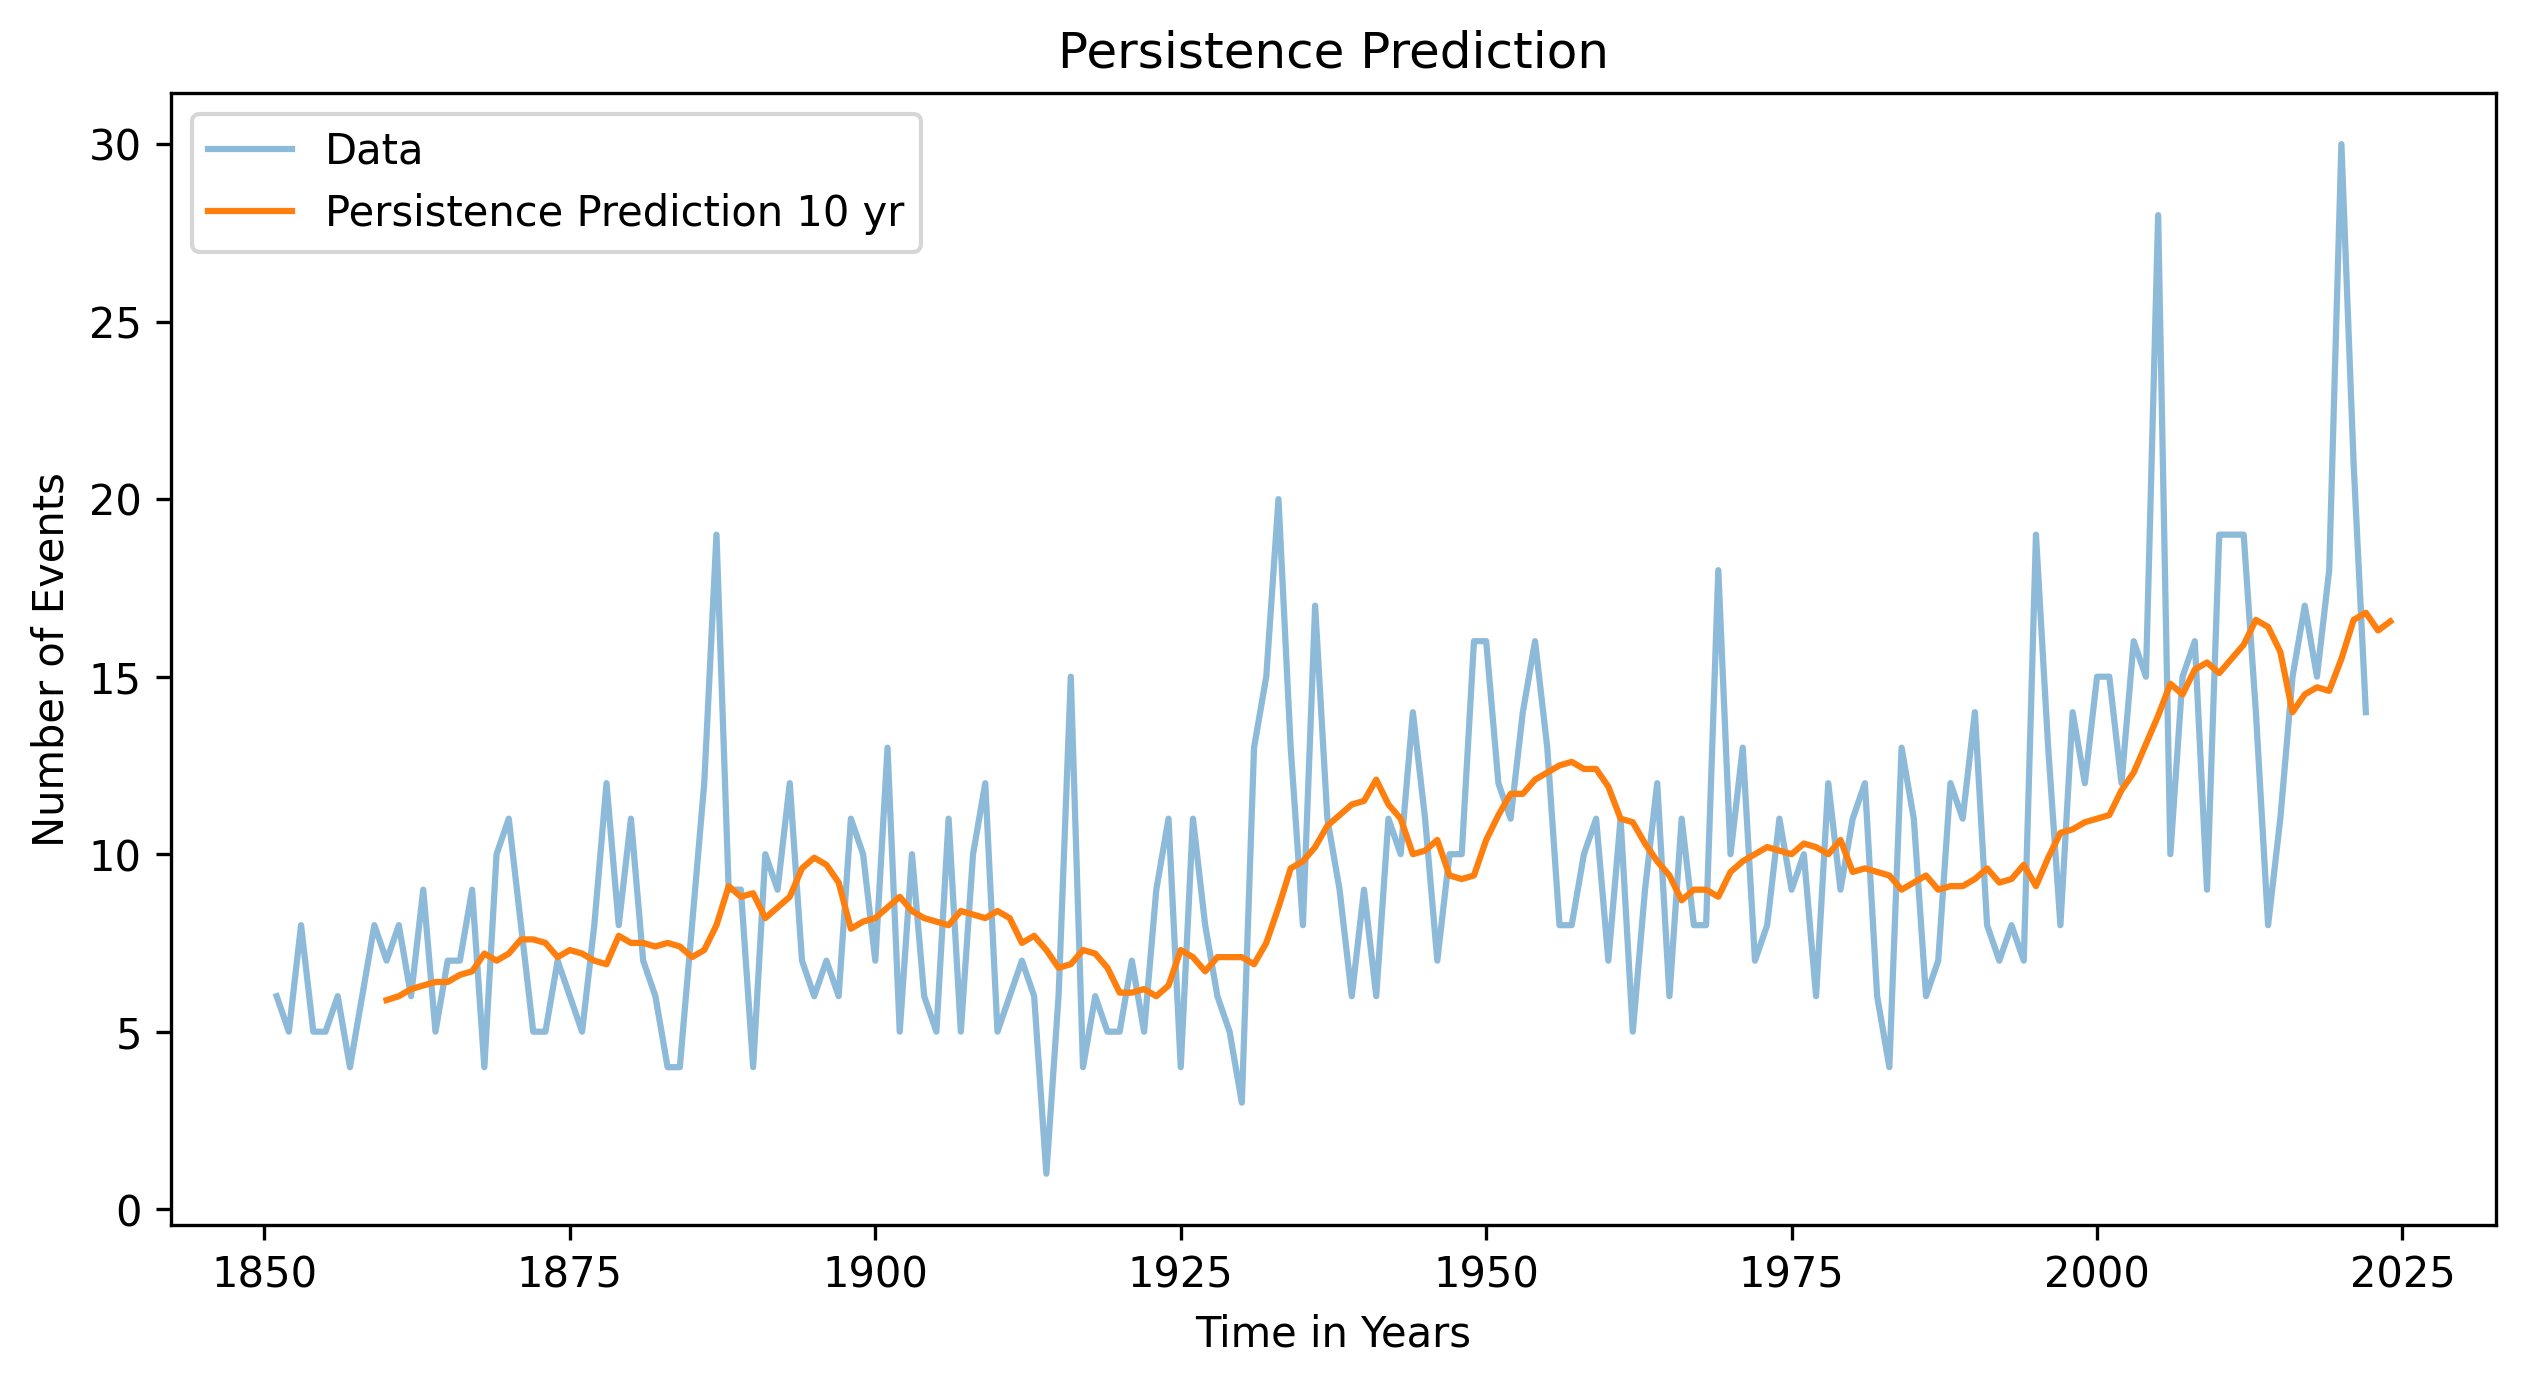

In [44]:
start_year = 1860
end_year = 2025
window_length = 10
#num_ly = 10
predict,years = pf.persistence_pred(df,start_year,end_year,window_length = window_length)

plt.figure(figsize = (10,5),dpi = 300)
plt.plot(df["Year"],df["Tropical Storms"], label = "Data",alpha = 0.5)
# for ly in range(num_ly):
#     plt.plot(np.arange(starts[ly],2025),predict[ly], label=f'LY = {ly}')
plt.plot(years,predict,label=f'Persistence Prediction {window_length} yr')
plt.legend(loc = "best")
plt.title(f"Persistence Prediction")
plt.xlabel("Time in Years")
plt.ylabel("Number of Events")
plt.legend()
plt.savefig(f"plots/persistence_window{window_length}.pdf")

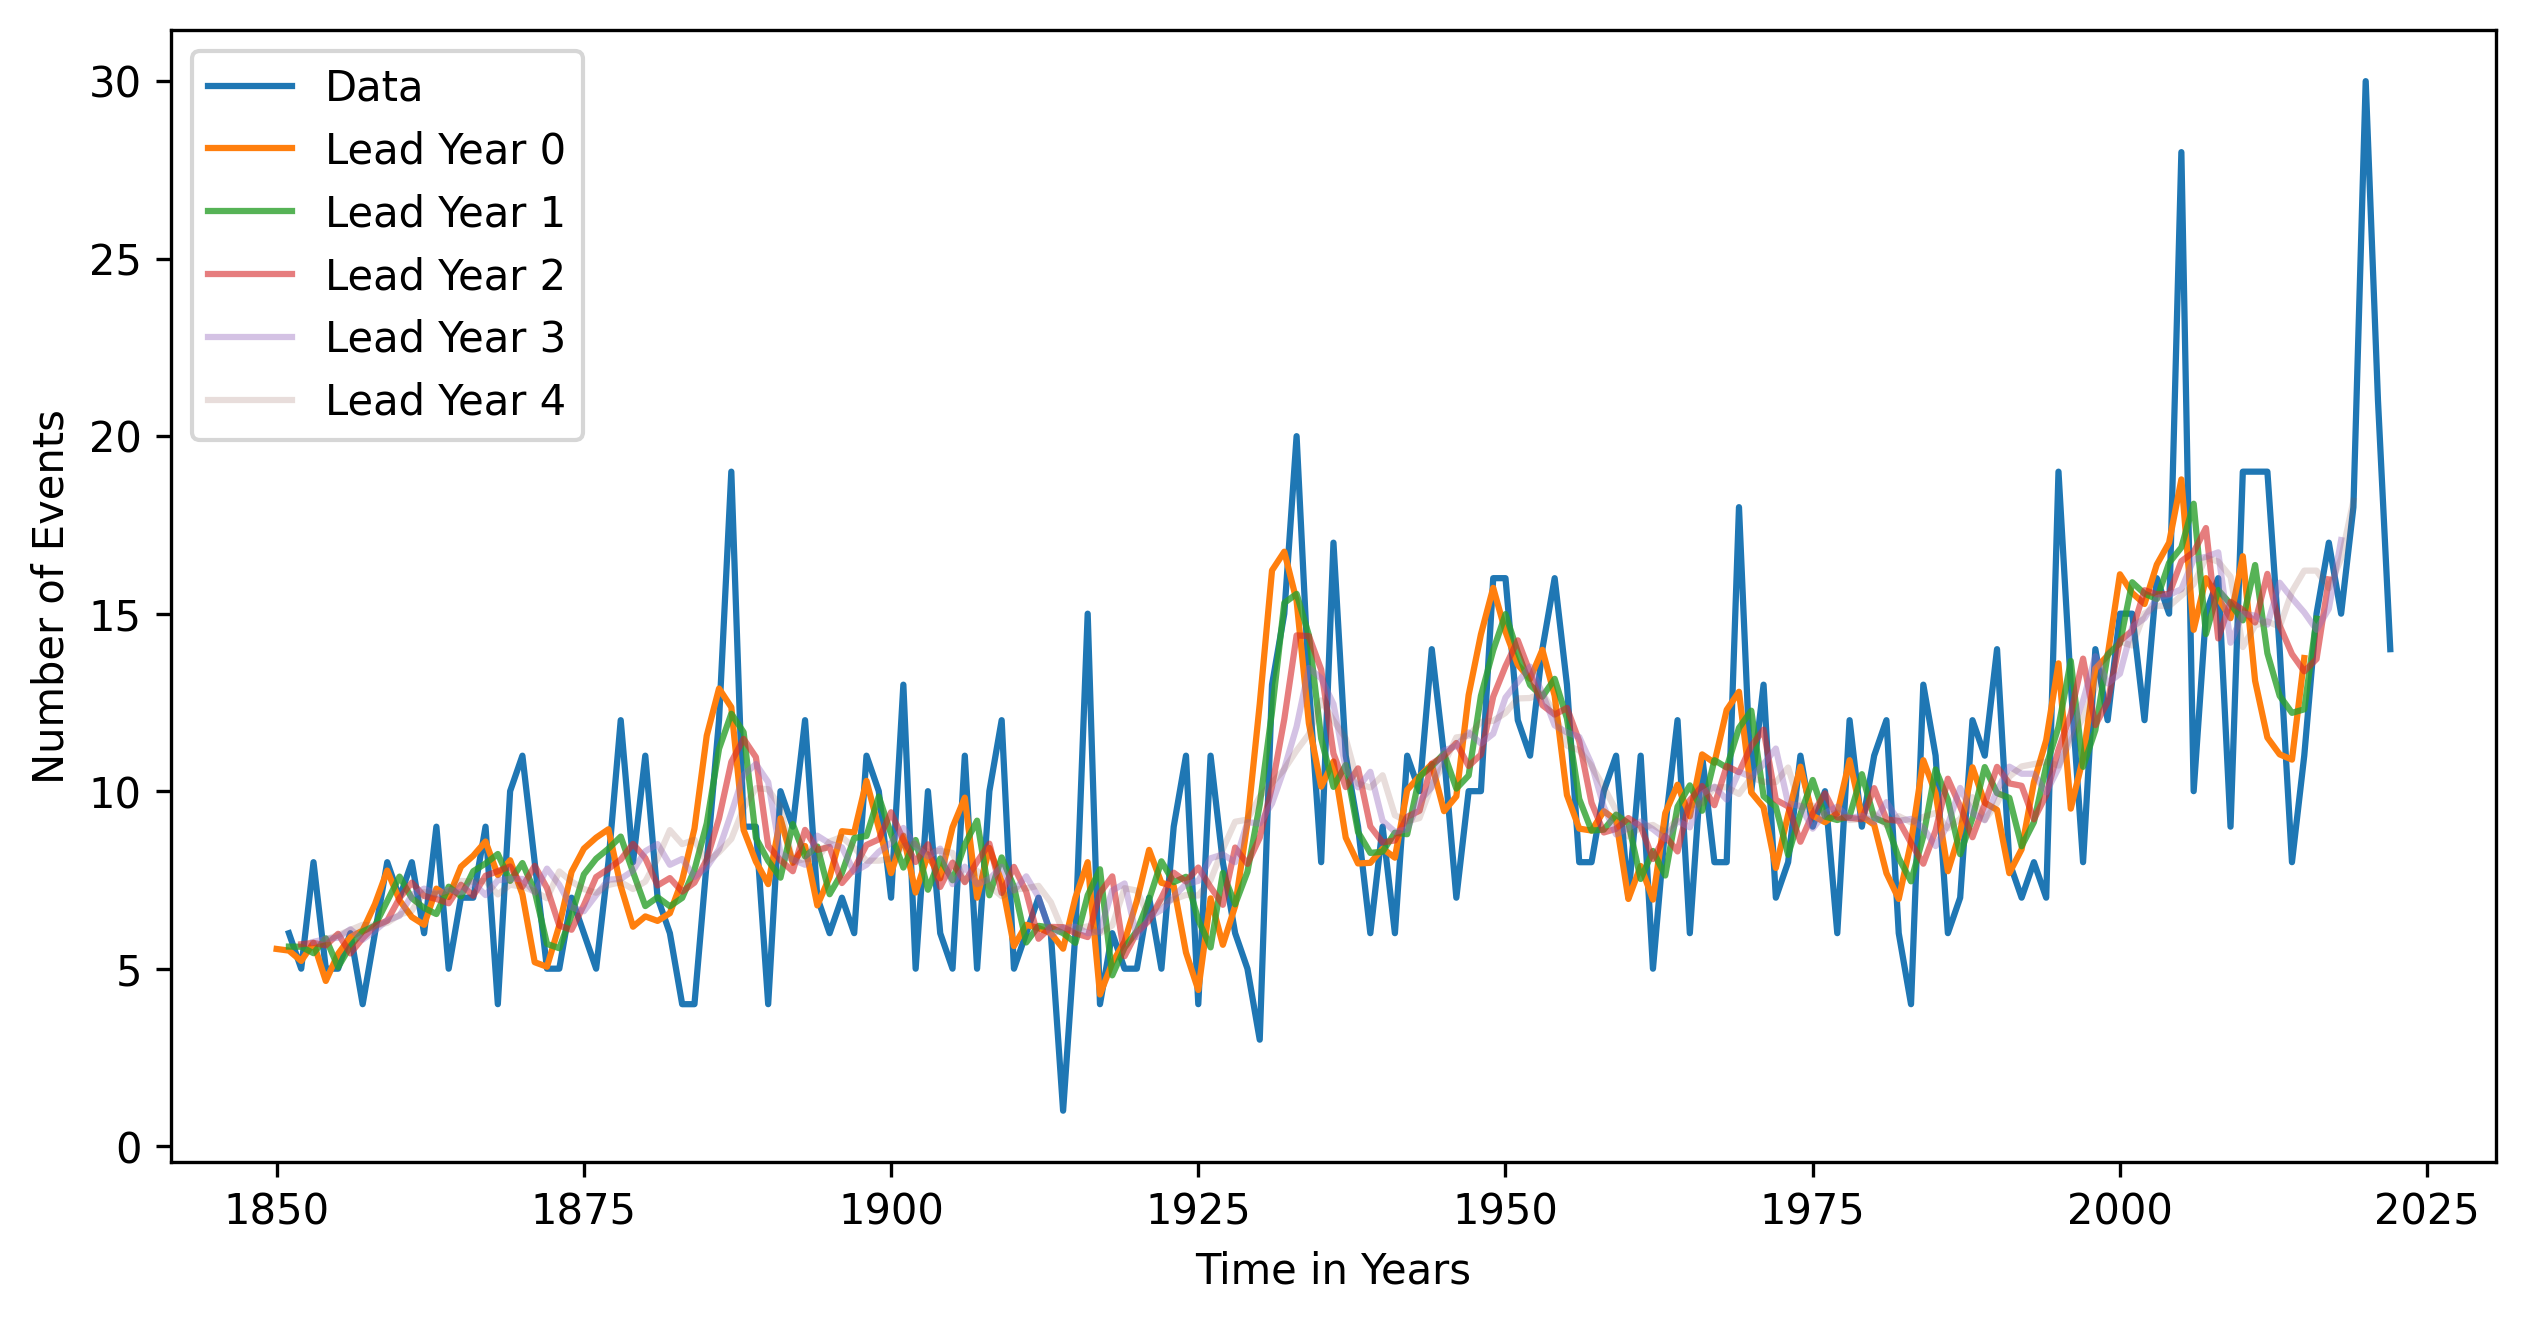

In [45]:
start_year = 1850
end_year = 2025
window_length = 10
num_ly = 10
predict,starts = pf.linear_reg_pred(df,start_year,end_year,window_length = window_length)
correlation = []

plt.figure(figsize = (10,5),dpi = 300)

plt.plot(df["Year"],df["Tropical Storms"], label = "Data")
for i in np.arange(5):
    ly_i = [prediction[i] for prediction in predict]
    correlation.append(np.corrcoef(ly_i,df["Tropical Storms"][0:len(ly_i)])[0,1])
    plt.plot(np.arange(len(ly_i))+starts[i],ly_i, label = f"Lead Year {i}", alpha = 1-(i*2)/10)
plt.xlabel("Time in Years")
plt.ylabel("Number of Events")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


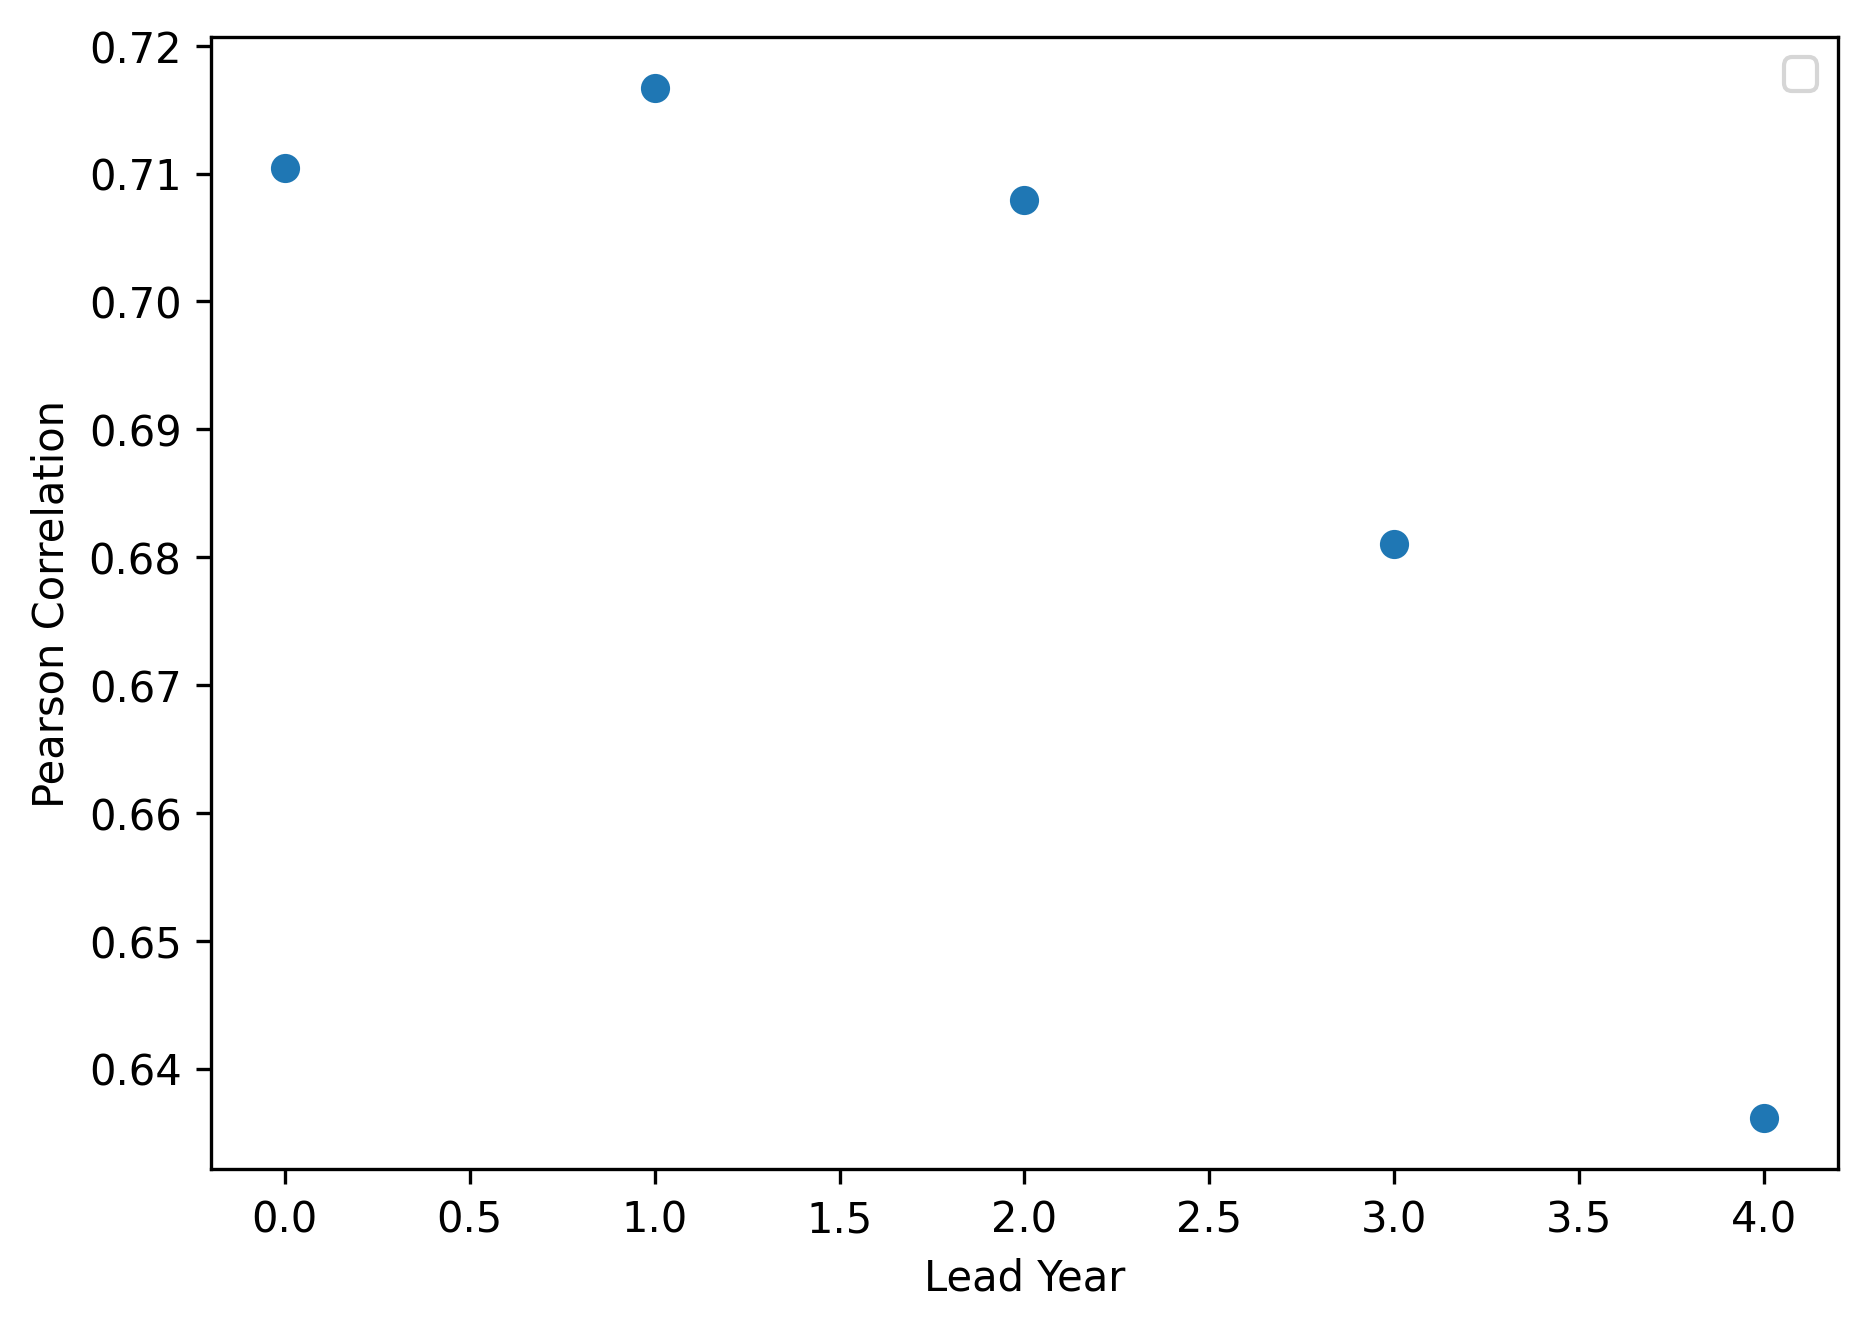

In [46]:
plt.figure(figsize = (7,5),dpi = 300)
plt.scatter(np.arange(len(correlation)),correlation)
plt.xlabel("Lead Year")
plt.ylabel("Pearson Correlation")
plt.legend()

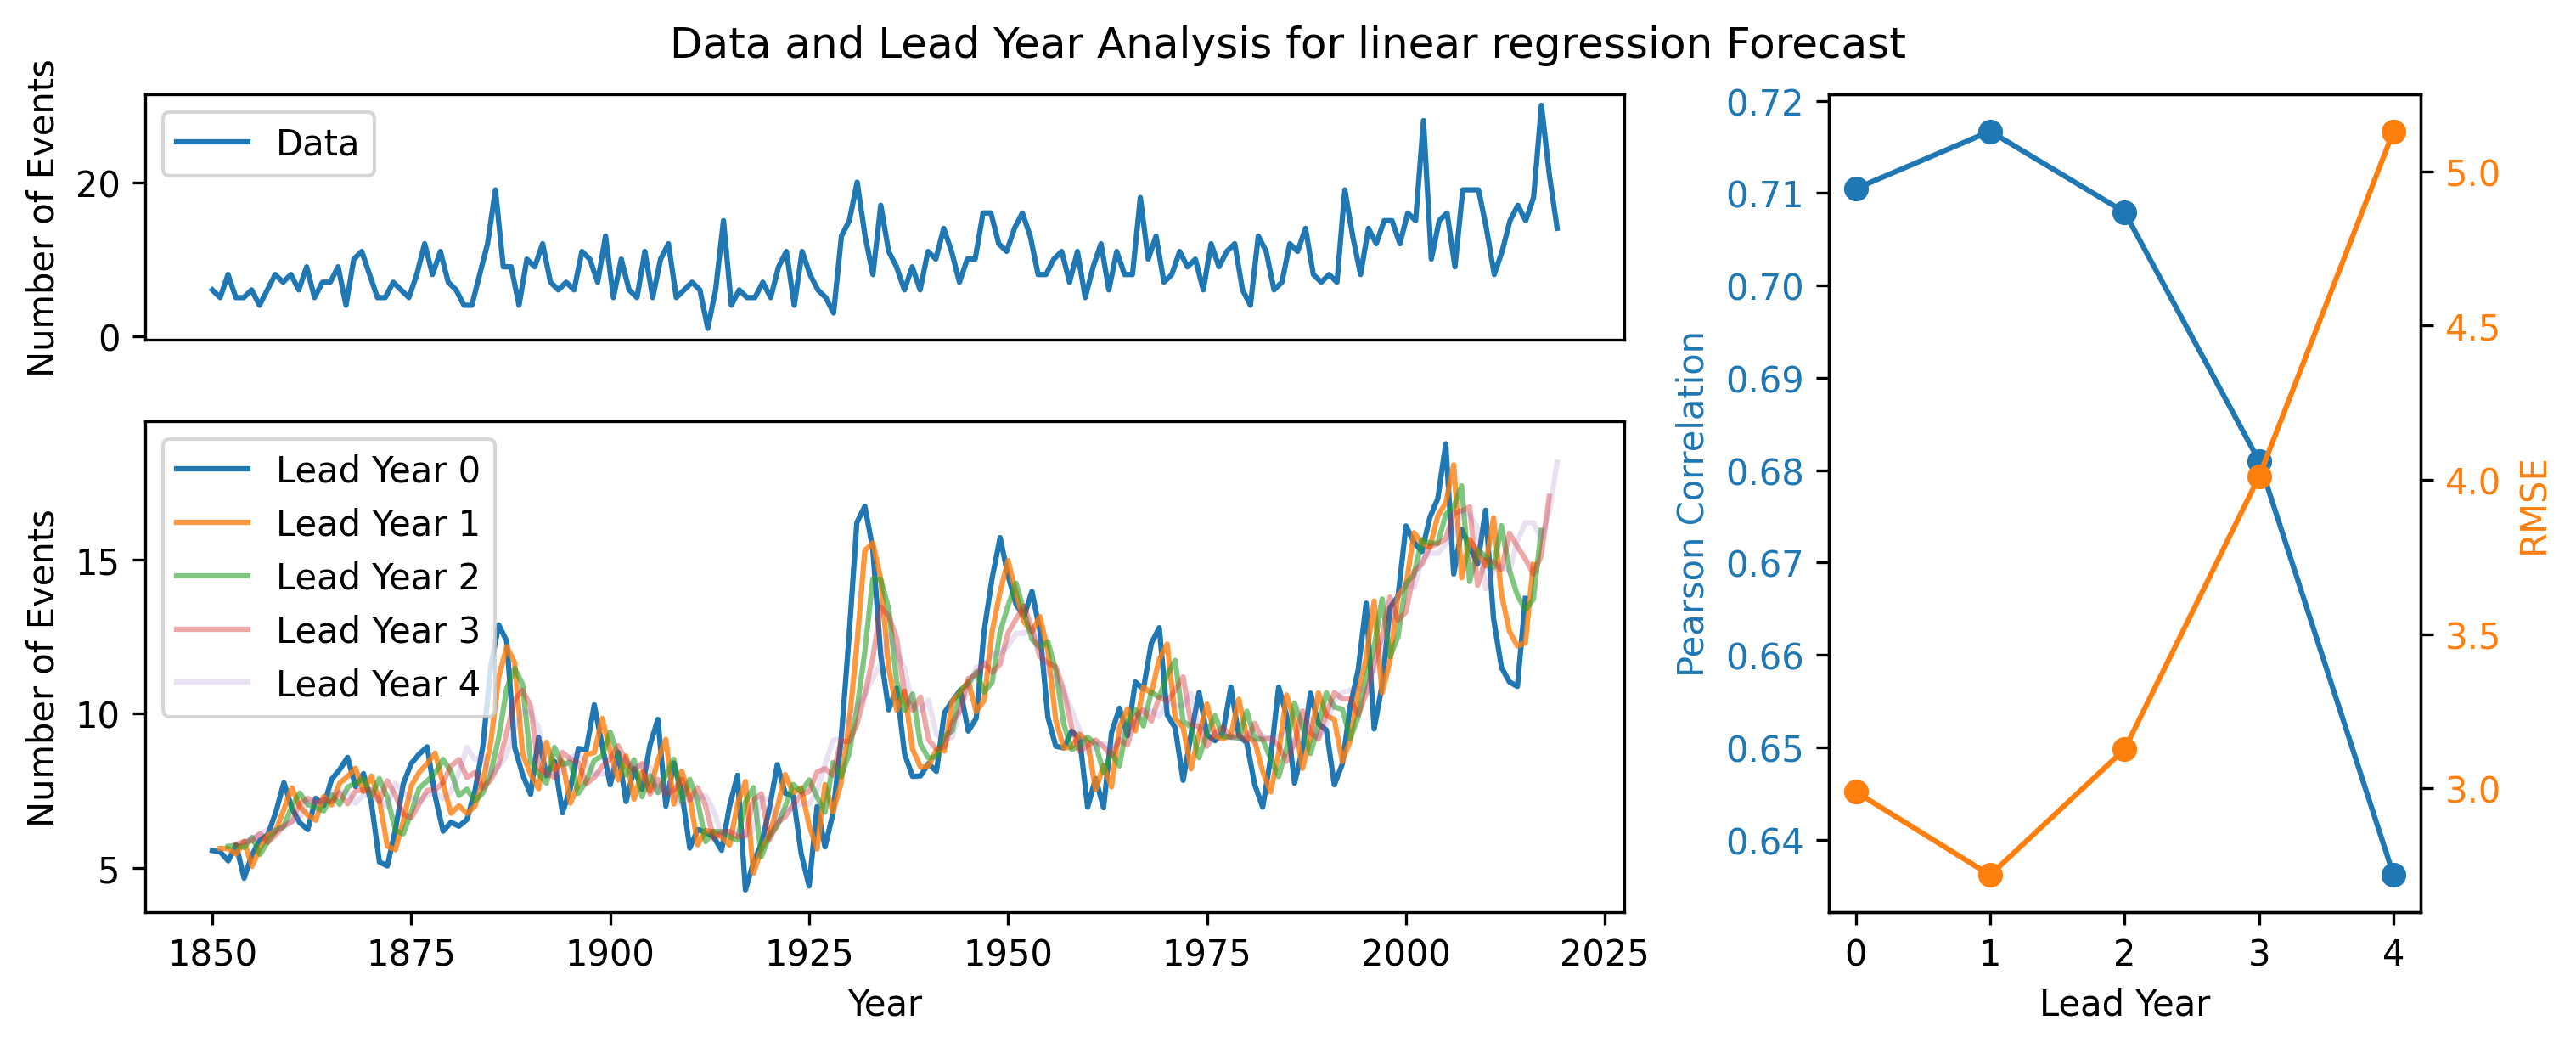

In [47]:
start_year = 1850
end_year = 2025
window_length = 10
num_ly = 10
predict,starts = pf.linear_reg_pred(df,start_year,end_year,window_length = window_length)
correlation = []

gs_kw = dict(width_ratios=[2.5, 1], height_ratios=[1, 2])
fig, axd = plt.subplot_mosaic([['upper left', 'right'],
                               ['lower left', 'right']],
                              gridspec_kw=gs_kw, figsize=(10, 4),
                              layout="constrained"
                              ,dpi = 300)

axd["upper left"].plot(df["Year"],df["Tropical Storms"], label = "Data")
axd["upper left"].set_xlabel("Year")
axd["upper left"].set_ylabel("Number of Events")
axd["upper left"].xaxis.set_visible(False)
axd["upper left"].legend()


for i in np.arange(5):
    ly_i = [prediction[i] for prediction in predict]
    correlation.append(np.corrcoef(ly_i,df["Tropical Storms"][0:len(ly_i)])[0,1])
    axd["lower left"].plot(np.arange(len(ly_i))+starts[i],ly_i, label = f"Lead Year {i}", alpha = 1-(i*2)/10)
axd["lower left"].set_xlabel("Year")
axd["lower left"].set_ylabel("Number of Events")
axd["lower left"].legend()


color = 'tab:blue'
axd["right"].plot(np.arange(len(correlation)),correlation,color=color,marker = "o")
axd["right"].set_xlabel("Lead Year")
axd["right"].set_ylabel("Pearson Correlation",color = color)
axd["right"].tick_params(axis='y', labelcolor=color)

ax2 = axd["right"].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE',color = color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(rmses)),rmses,color = color,marker = "o")
ax2.tick_params(axis='y', labelcolor=color)
#axd["right"].legend()

fig.suptitle('Data and Lead Year Analysis for linear regression Forecast')

plt.savefig(f"plots/Lead_year_regression_forecast.pdf")
plt.savefig(f"plots/Lead_year_regression_forecast.jpg")

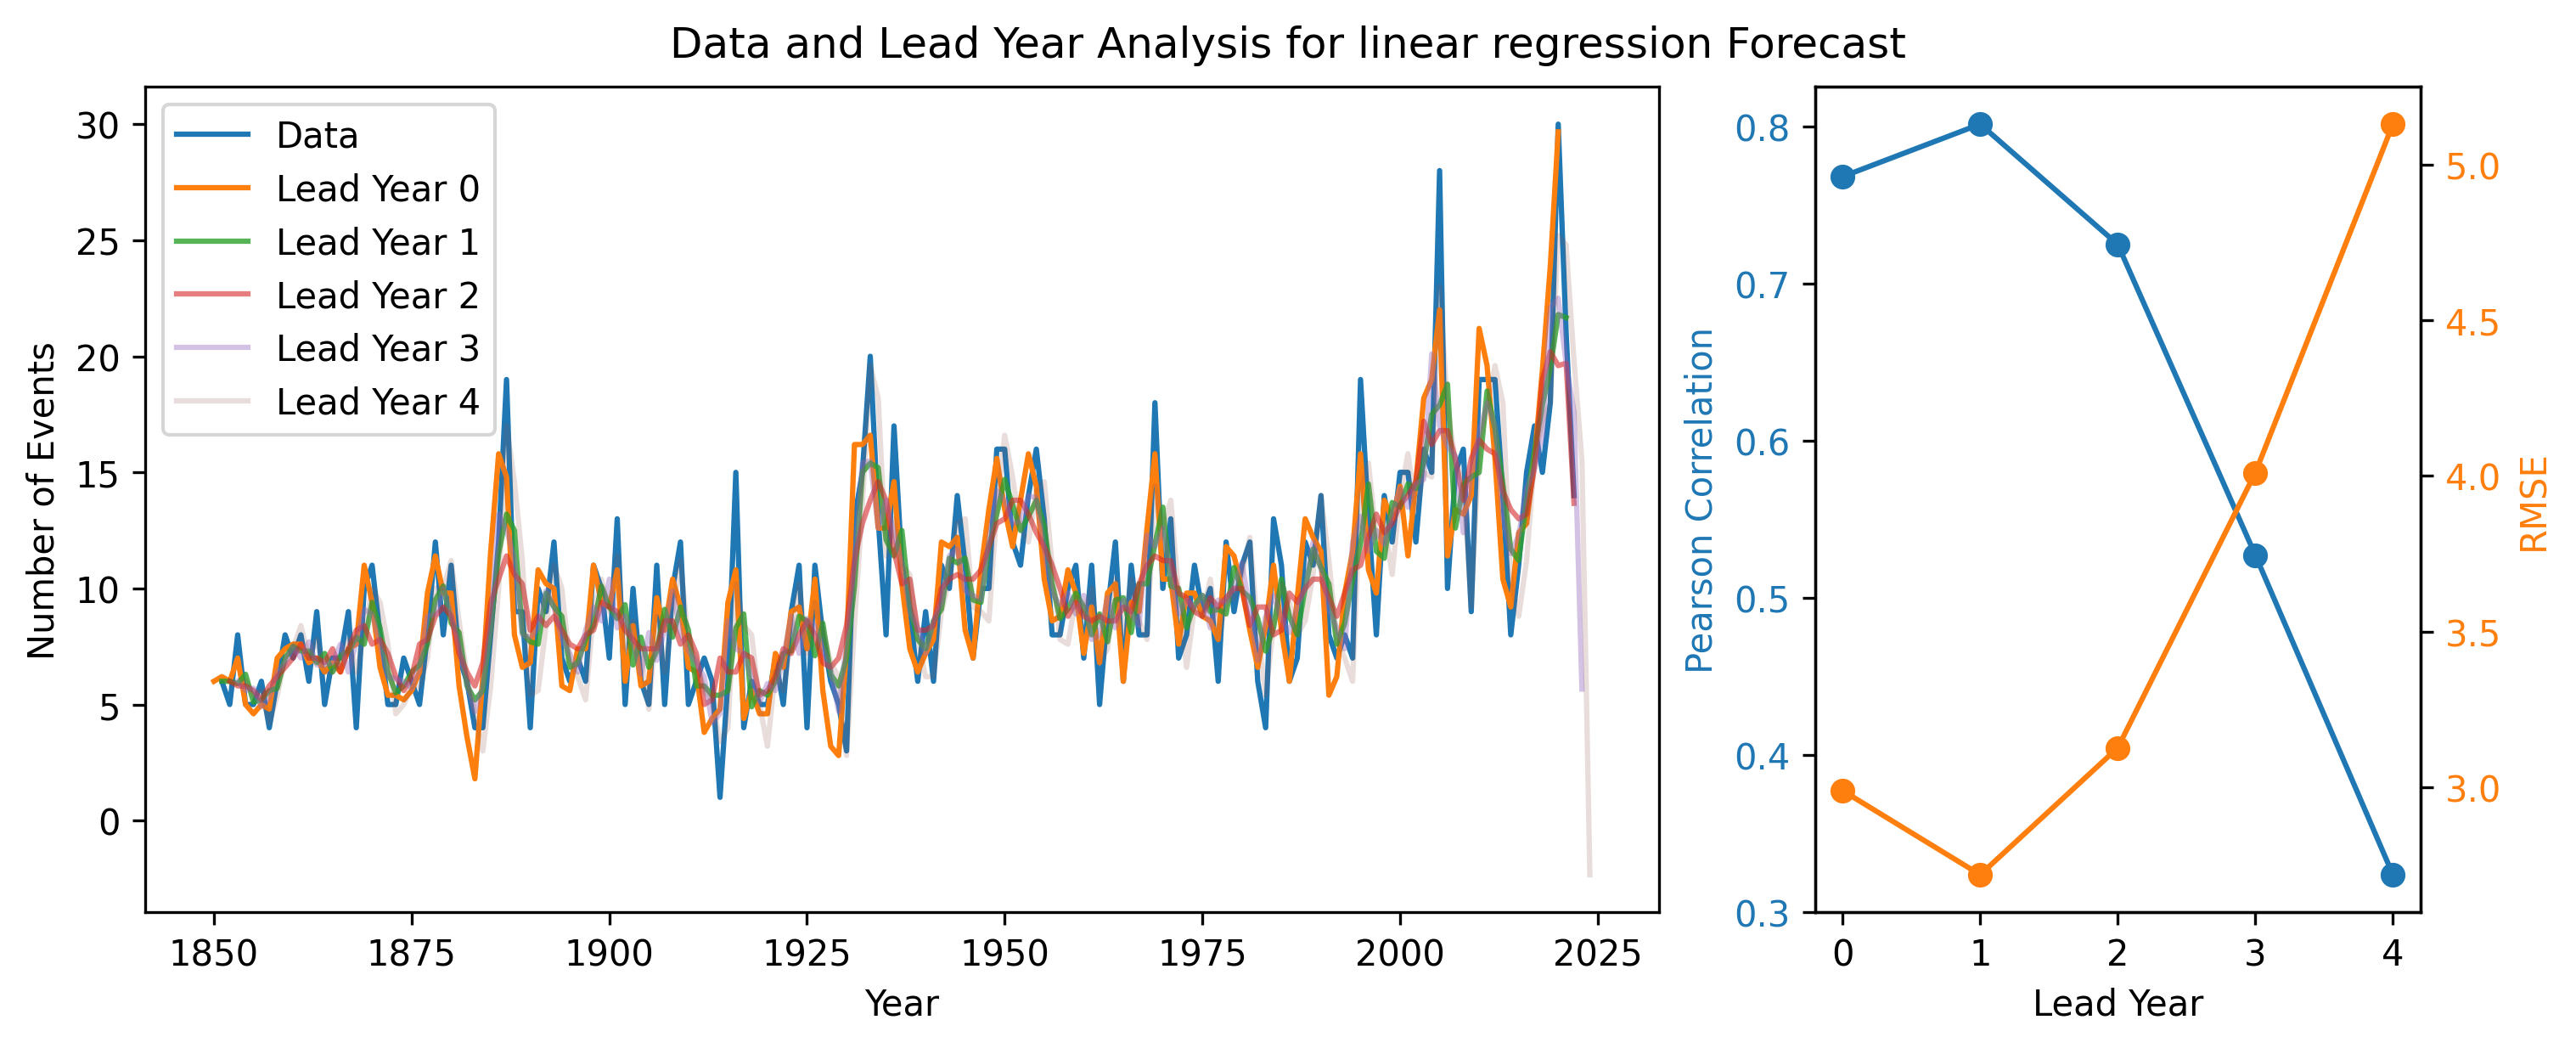

In [48]:
start_year = 1850
end_year = 2025
window_length = 5
num_ly = 10
predict,starts = pf.linear_reg_pred(df,start_year,end_year,window_length = window_length)
correlation = []
rmses = []

gs_kw = dict(width_ratios=[2.5, 1])
fig, axd = plt.subplot_mosaic([['left', 'right']],
                              gridspec_kw=gs_kw, figsize=(10, 4),
                              layout="constrained"
                              ,dpi = 300)

axd["left"].plot(df["Year"],df["Tropical Storms"], label = "Data")
# axd["left"].set_xlabel("Year")
# axd["left"].set_ylabel("Number of Events")
# axd["left"].xaxis.set_visible(False)
# axd["left"].legend()


for i in np.arange(5):
    ly_i = [prediction[i] for prediction in predict]
    correlation.append(np.corrcoef(ly_i,df["Tropical Storms"][0:len(ly_i)])[0,1])
    rmses.append(rmse(ly_i,df["Tropical Storms"][0:len(ly_i)]))
    axd["left"].plot(np.arange(len(ly_i))+starts[i],ly_i, label = f"Lead Year {i}", alpha = 1-(i*2)/10)
axd["left"].set_xlabel("Year")
axd["left"].set_ylabel("Number of Events")
axd["left"].legend()


color = 'tab:blue'
axd["right"].plot(np.arange(len(correlation)),correlation,color=color,marker = "o")
axd["right"].set_xlabel("Lead Year")
axd["right"].set_ylabel("Pearson Correlation",color = color)
axd["right"].tick_params(axis='y', labelcolor=color)

ax2 = axd["right"].twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE',color = color)  # we already handled the x-label with ax1
ax2.plot(np.arange(len(rmses)),rmses,color = color,marker = "o")
ax2.tick_params(axis='y', labelcolor=color)
#axd["right"].legend()

fig.suptitle('Data and Lead Year Analysis for linear regression Forecast')

plt.savefig(f"plots/Lead_year_regression_forecast.pdf")
plt.savefig(f"plots/Lead_year_regression_forecast.jpg")

In [49]:
from scipy.fft import fft, fftfreq
import numpy as np
